## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv("data\kc_house_data.csv")

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The first thing we will want to do is remove any information that does not pertain to the question we are trying to answer. We will remove columns that have similar values or do not pertain to renovation and pricing.

In [225]:
todrop = ["date", "sqft_above", "sqft_basement", "view", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15", "yr_renovated"]

In [226]:
df1 = df.drop(labels=todrop, axis=1)
df1.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


In [227]:
df1.dtypes

id               int64
price          float64
bedrooms         int64
bathrooms      float64
sqft_living      int64
sqft_lot         int64
floors         float64
waterfront      object
condition       object
grade           object
yr_built         int64
dtype: object

First we want to check for any Nan or zero values in the dataframe and remove those rows.

In [228]:
df1.isnull().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [230]:
df1 = df1.dropna()

In [231]:
df1.isnull().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
condition      0
grade          0
yr_built       0
dtype: int64

In [232]:
df1.all()

id             True
price          True
bedrooms       True
bathrooms      True
sqft_living    True
sqft_lot       True
floors         True
waterfront     True
condition      True
grade          True
yr_built       True
dtype: bool

Looks like we should be good to go with our current information.

Lets convert the categorical columns into numeric columns to be read by the model. Starting with condition and grade

In [233]:
df1['condition'].unique()

array(['Average', 'Very Good', 'Good', 'Poor', 'Fair'], dtype=object)

In [234]:
df1['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [235]:
df1.loc[df['condition'] == "Poor", 'condition_num'] = 1 
df1.loc[df['condition'] == "Fair", 'condition_num'] = 2
df1.loc[df['condition'] == "Average", 'condition_num'] = 3 
df1.loc[df['condition'] == "Good", 'condition_num'] = 4
df1.loc[df['condition'] == "Very Good", 'condition_num'] = 5

In [236]:
df1['grade_num'] = df1['grade'].astype(str).str[0]
df1['grade_num'] = df1['grade_num'].astype(float)

In [194]:
# df1["meets_building_code"] = (df1['grade_num'] > 5).astype(int)
# df1['highend_finishes'] = (df1['grade_num'] > 10).astype(int)
# df1['maintained'] = (df1['condition_num'] > 3).astype(int)

And now lets do waterfront

In [238]:
df1.loc[df['waterfront'] == "NO", 'waterfront'] = 0
df1.loc[df['waterfront'] == "YES", 'waterfront'] = 1

There may be some duplicates of houses in here as well so lets remove all duplicates

In [239]:
df2 = df1

In [240]:
df2 = df2.drop_duplicates(subset='id', keep='last')

In [241]:
df2['price'] = df2['price']/1000000
df2 = df2.drop(labels=['id', 'condition', 'grade'], axis=1)

Lets break up the data into the test and train datasets to take a look at the scatterplots for each category as they relate to price.

In [242]:
train = df2
test = df2

X_train = train.drop("price", axis=1)
y_train = train["price"]

X_test = test.drop("price", axis=1)
y_test = test["price"]

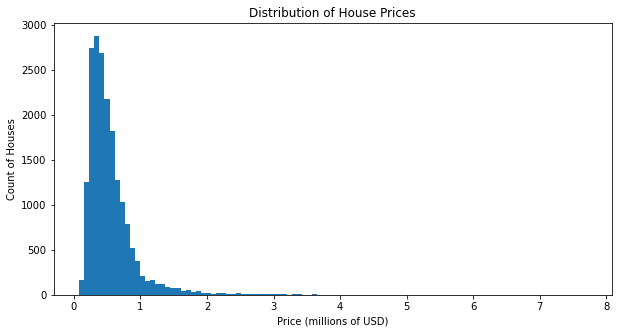

In [243]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_train, bins=100)

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Price (millions of USD)")
ax.set_ylabel("Count of Houses")
ax.set_title("Distribution of House Prices");

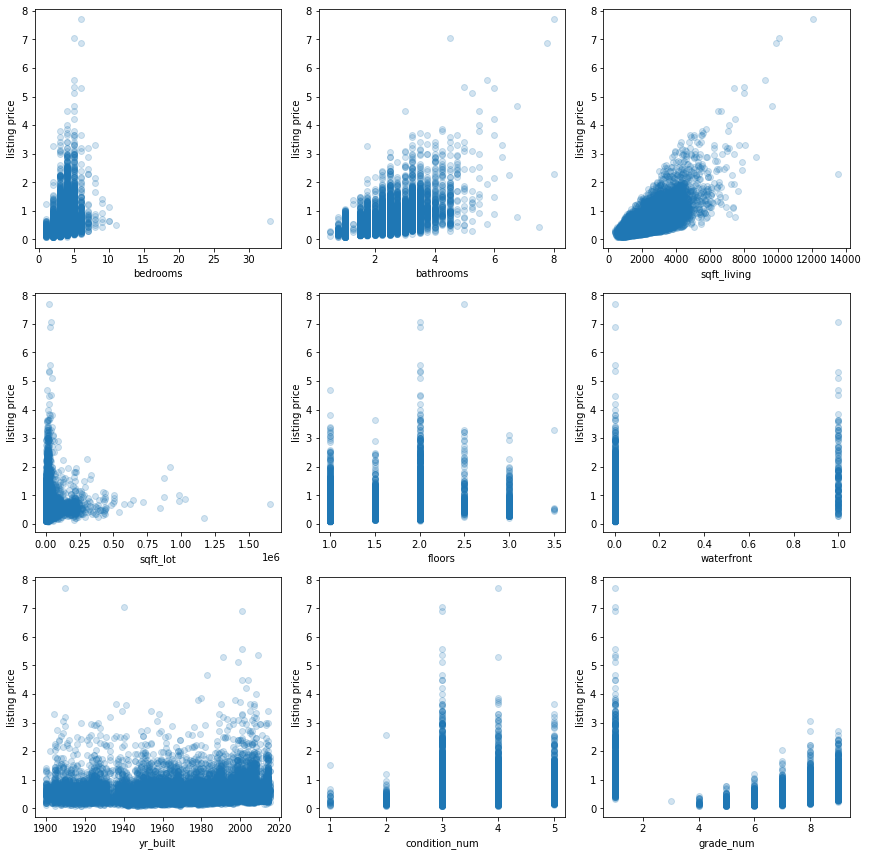

In [244]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
fig.set_tight_layout(True)

for index, col in enumerate(X_train.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

One thing we have to address is all of the grade number 1 houses in the grade_num plot. Kings County must have used the lowest grade as a default for some houses, or there may be houses that are listed as foreclosures that have a low grade due to poor maintenance. We will take these out to avoid skewing our results.

In [245]:
df3 = df2[df2.grade_num != 1]

In [246]:
train = df3
test = df3

X_train = train.drop("price", axis=1)
y_train = train["price"]

X_test = test.drop("price", axis=1)
y_test = test["price"]

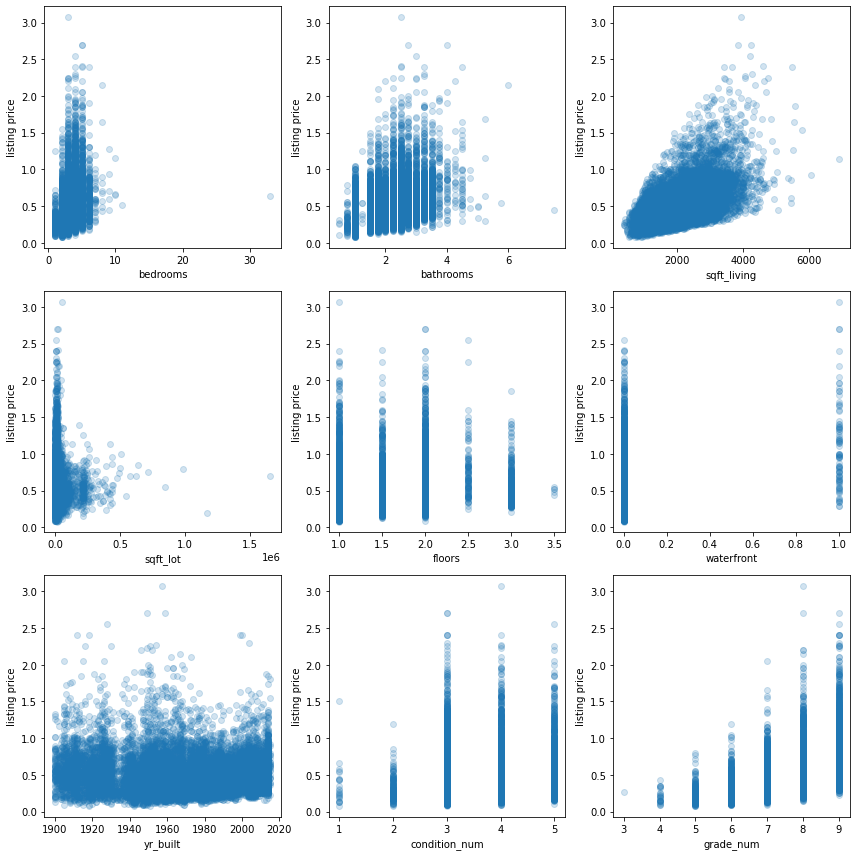

In [247]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
fig.set_tight_layout(True)

# Create a grid of plots for each category
for index, col in enumerate(X_train.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

Now that our data looks good, and nothing looks off in the scatter plots, we will create a heatmap of correlation between the values

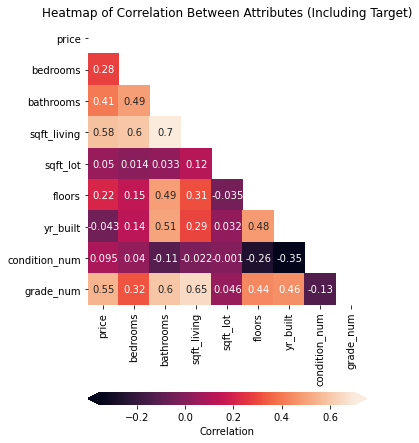

In [248]:
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(5, 8))

sns.heatmap(
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

Looks like the sqft_living, grade_num and bathrooms are the the highest correlated indicators of price.The correlation value is not high but there is one there. We will use these when creating our second model.

Now we will want to create a baseline model to compare our results to as we work through this problem. We will use sqft_living to create the baseline model to compare to.

In [218]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

In [219]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[['sqft_living']],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.3441514056690382
Validation score: 0.32431066756850785


Well our current baseline model really is not great. The R squared scores are less than desirable at 0.34 and 0.32 each. Maybe that will change when we introduce the other variables we identified previously that are strongly correlated to the price of a house.

In [220]:
drops = ['bedrooms', 'sqft_lot', 'floors', 'condition_num']

X_train_second_model = X_train.drop(drops, axis=1)

X_train_second_model

,bathrooms,sqft_living,grade_num
0,1.00,1180,7.0
1,2.25,2570,7.0
2,1.00,770,6.0
3,3.00,1960,7.0
4,2.00,1680,8.0
...,...,...,...
21592,2.50,1530,8.0
21593,2.50,2310,8.0
21594,0.75,1020,7.0
21595,2.50,1600,8.0


Before we model this, it might be a good idea to scale the variables here, considering that all of these

In [221]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.3974375047361145
Validation score: 0.38158968382698416

Baseline Model
Train score:      0.3441514056690382
Validation score: 0.32431066756850785


This combination of features in the second model definitely increased the train and validation score, though these scores are still lower than we would want for linear regression. Lets try and sift through for multicollinearity.

We are focused on providing advice to homeowners about how home renovations might increase the value of their homes. 

First we have to determine if home renovations will in fact increase the value of the home significantly. Not sure how significantly though, or even if they are increased at all. Intuitively, I believe renovations increase home value but there are renovations that do not provide a ROI at all, so renovating a house does not automatically mean that the value increases. Given this:

Null Hypothesis:

- $H_0$: Price of houses with no renovations => Price of houses with renovations

Alternative Hypothesis:

- $H_1$: Price of houses with no renovations < Price of houses with renovations



